# Transfer Learning w/ Augmentation

Closely modeled after fast.ai's [NLP course](https://github.com/fastai/course-nlp). But now, we have to take care to augment only the training set (so that we don't expose the model to samples very similar to the ones in the test set).

### Settings & Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os.path
import numpy as np
from utils import preprocess
from fastai.text import *

### Data Preprocessing

In [3]:
@classmethod
def from_csv_augmented(cls, path, original_data_name="preprocessed_data.csv", 
                       augmented_data_name="augmented_data.csv", 
                       valid_pct=0.2, text_cols="tweet", label_cols="class",
                       augment_hate_only = False,
                       **kwargs):
    
    '''Closely follows fastai's DataBunch::TextDataBunch::from_csv,
       (https://github.com/fastai/fastai/blob/master/fastai/text/data.py#L210)
       but accounts for data augmentation. The train/valid split is generated based on the original dataset,
       then only the training set is augmented before the DataBunch is generated.
       
       NOTE: augmented_data.csv contains an idx column that maps an augmented sample to
       the corresponding non-augmented tweet. This column is the key to augment the training
       set only.
    '''
    
    # Load dataframes
    df = pd.read_csv(Path(path)/original_data_name, header="infer")
    df_aug = pd.read_csv(Path(path)/augmented_data_name, header="infer")
    
    # Shuffle 
    df = df.iloc[np.random.permutation(len(df))]
    
    # Split train and valid sets
    cut = int(valid_pct * len(df)) + 1
    train_df_temp, valid_df = df[cut:], df[:cut]
    
    if augment_hate_only:
        print("Augmenting hate speech class only.")
        hate = train_df_temp.loc[train_df_temp["class"] == 0]
        non_hate = train_df_temp.loc[train_df_temp["class"] != 0][["tweet", "class"]]
        aug_hate = df_aug.loc[df_aug["idx"].isin(hate.index), :][["tweet", "class"]]
        train_df = pd.concat([non_hate, aug_hate])
        
    else:
        # Augment the entire training set
        train_df = df_aug.loc[df_aug["idx"].isin(train_df_temp.index), :]
        
    # Shuffle again
    train_df = train_df.iloc[np.random.permutation(len(train_df))]
    
    return cls.from_df(path, train_df, valid_df, text_cols=text_cols, label_cols=label_cols, **kwargs)

TextClasDataBunch.from_csv_augmented = from_csv_augmented

In [4]:
path = "./data"
bs = 128  # Batch size

# If files have been saved, load them.
try:
    
    data_lm = load_data(path, 'augdata_lm_export.pkl', bs=bs)
    data_clas = load_data(path, 'augdata_clas_export.pkl', bs=bs)
    data_bwd = load_data(path, 'augdata_lm_export.pkl', bs=bs, backwards=True)
    data_clas_bwd = load_data(path, 'augdata_clas_export.pkl', bs=bs, backwards=True)
    print("Saved files loaded successfully...\n")
    
except:
    
    print("Files not found. Creating data files...\n")
    
    # Language model data
    data_lm = TextLMDataBunch.from_csv(path, 'augmented_data.csv', text_cols='tweet', bs=bs)
    # Classifier model data
    data_clas = TextClasDataBunch.from_csv_augmented(path, vocab = data_lm.train_ds.vocab, bs=bs, augment_hate_only=True)
    
    # Save files
    data_lm.save('augdata_lm_export.pkl')
    data_clas.save('augdata_clas_export.pkl')
    
    # Load backwards data
    data_bwd = load_data(path, 'augdata_lm_export.pkl', bs=bs, backwards=True)
    data_clas_bwd = load_data(path, 'augdata_clas_export.pkl', bs=bs, backwards=True)

Saved files loaded successfully...



In [5]:
data_lm.show_batch()

idx,text
0,"xxup rt xxup mentionhere : idgaf what you bitches say about me 😂 xxbos xxup rt xxup mentionhere : xxmaj girls "" go talk to your other hoes "" game too strong xxbos xxup rt xxup mentionhere : xxmaj in the xxmaj yankees draft room , they had a huge picture of xxmaj greg xxmaj campbell with the message , "" this is the makeup we 're looking for ."
1,actually want to kick y' all in the ovaries . ” xxbos xxup rt xxup mentionhere : xxmaj rt if you killed a bitch with your dick xxbos xxup rt xxup mentionhere : need my dick sucked .. fuck 1 bitch i need ✌ ️ sluts xxbos xxmaj my white queen dreading her hairs . xxmaj thank you xxmaj most xxmaj high for another xxmaj moor xxmaj queen i asked
2,"standing in rear of him looking like rogue from the xmen xxbos xxup rt xxup mentionhere : xxmaj my body count had from 4 to 11 in one semester ... i 'm not a hoe really love sex xxup -famu xxbos xxmaj he be like "" bitch dontouch her braids "" xxbos xxup rt xxup mentionhere : xxmaj go dumb bitch do their dumb dance xxbos xxup rt xxup mentionhere"
3,apes of the four calling birds of the three french hens of the two turtle doves of the partridge in … xxbos xxup rt xxup mentionhere : it 's these fun and games after i have to slap a bitch xxbos xxup rt xxup mentionhere : u a hoe if you have parents and you 're n't awake xxbos xxup rt xxup mentionhere : xxmaj thanks to xxup mentionhere i
4,"cloud do ? xxbos xxmaj she do nt wanna fuck me she wanna fuck my wrist .. let her like young dro fuck dat bitch xxbos i love bad bitches that 's my fuckin problem . xxbos xxmaj you always find something to bitch about . xxbos xxmaj slack jawed yokel daughter xxup urlhere xxbos xxmaj their got ta be a loaded lux vs xxmaj murda mook 3 xxbos """


In [6]:
data_clas.show_batch()

text,target
xxbos xxup rt xxup mentionhere : xxup rt if you like xxup bmth xxup adtr xxup ptv xxup ymas xxup sws xxup atl xxup om&&m xxup aa xxup miw xxup btf xxup wcar xxup mcr xxup afi xxup pe xxup bvb xxup wim xxup bc xxup ss xxup cte xxup nsn xxup gd xxup watic xxup aa xxup bfmv xxup fob f …,2
xxbos xxup rt xxup mentionhere : i xxmaj be xxmaj like 🚗 xxrep 13 _ 🚓 xxmaj fuck xxmaj here come the 5'o _ _ 🚗 xxrep 6 _ 🚓 _ _ xxmaj be cool son _ _ _ 🚗 🚓 xxrep 5 _ xxmaj man fuck _ _ _ 🚓 _ _ _ 🚗 xxrep 4 _ bitch ass …,1
xxbos “ xxup mentionhere : xxmaj my xxmaj anaconda xxmaj do n't xxmaj my xxmaj anaconda xxmaj do n't xxmaj my xxmaj anaconda xxmaj do n't xxmaj want xxmaj none xxmaj unless xxmaj you xxmaj got xxup goals xxmaj hun xxunk xxunk xxunk 💰 🏡 👫 💍 ” xxmaj smh . xxmaj white xxmaj ass niggah .,1
"xxbos xxup rt xxup mentionhere : xxup br xxrep 6 u h xxrep 4 😭 xxrep 4 😂 “ xxup mentionhere : xxmaj kobe , last night yelling at xxmaj dwight xxmaj howard : "" xxmaj you a bitch ass n xxrep 5 * "" ? xxup urlhere # 8230 ;",1
"xxbos xxup rt xxup mentionhere : xxmaj jaheim , xxmaj donell xxmaj jones , xxmaj lyfe xxmaj jennings , xxmaj ginuwine , xxmaj charlie xxmaj wilson , xxmaj dru xxmaj hill , xxup next , xxmaj jodeci , xxmaj tyrese and etc xxrep 6 . bring xxup that type …",2


### Fine-Tuning (Forward)

In [7]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


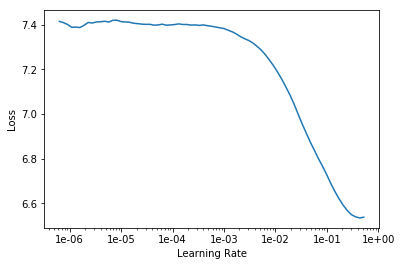

In [8]:
learn_lm.recorder.plot(skip_end=15)

In [9]:
learn_lm.fit_one_cycle(1, 1e-1,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.810081,4.253870,0.274973,00:54


In [10]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(40, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.412588,4.186768,0.279519,01:06
1,4.325269,4.118681,0.284931,01:07
2,4.239810,4.028430,0.289633,01:07
3,4.114364,3.909237,0.303100,01:07
4,3.972497,3.761214,0.317279,01:07
5,3.802368,3.592617,0.334348,01:07
6,3.639961,3.421285,0.352284,01:07
7,3.461323,3.243647,0.376843,01:07
8,3.283544,3.088894,0.397007,01:07
9,3.143115,2.939489,0.420097,01:07


In [11]:
learn_lm.save_encoder('fwd_enc')

### Fine-Tuning (Backward)

In [12]:
learn_bwd = language_model_learner(data_lm, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)

In [13]:
learn_bwd.fit_one_cycle(1, 1e-1,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.807450,4.247264,0.275040,00:55


In [14]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(40, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.412086,4.179175,0.279129,01:07
1,4.318441,4.110283,0.285169,01:07
2,4.221370,4.017302,0.293688,01:07
3,4.114396,3.901275,0.303723,01:07
4,3.956947,3.753481,0.317287,01:07
5,3.793473,3.589337,0.334125,01:07
6,3.632738,3.412024,0.354702,01:07
7,3.454860,3.241322,0.376848,01:07
8,3.280578,3.083799,0.397510,01:07
9,3.148256,2.934880,0.420950,01:07


In [15]:
learn_bwd.save_encoder('bwd_enc')

### Classifier (Forward)

In [5]:
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class.load_encoder('fwd_enc')
learn_class.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


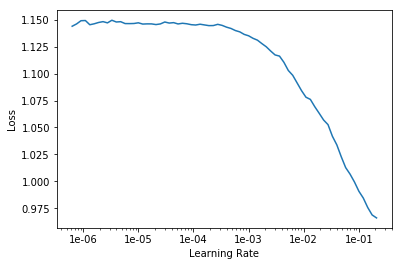

In [6]:
learn_class.lr_find()
learn_class.recorder.plot(skip_end=15)

In [7]:
lr = 5e-2
learn_class.fit_one_cycle(2, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.730494,0.553090,0.812387,00:18
1,0.658861,0.495676,0.817833,00:18


In [8]:
learn_class.save('1st')

In [9]:
learn_class.freeze_to(-2)
lr /= 5
learn_class.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.577988,0.418763,0.841033,00:22


In [10]:
learn_class.save('2nd')

In [11]:
learn_class.freeze_to(-3)
lr /= 2
learn_class.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.433379,0.340941,0.872504,00:36


In [12]:
learn_class.save('3rd')

In [13]:
learn_class.unfreeze()
lr /= 5
learn_class.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.282087,0.342775,0.876337,00:48
1,0.231760,0.344949,0.878757,00:47


In [14]:
learn_class.save('fwd_clas')

### Classifier (Backward)

In [15]:
learn_class_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class_bwd.load_encoder('bwd_enc')
learn_class_bwd.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


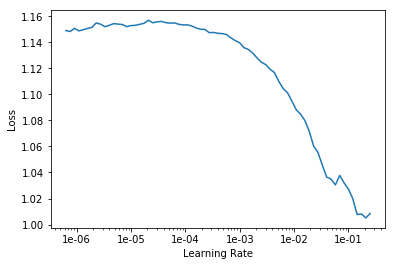

In [16]:
learn_class_bwd.lr_find()
learn_class_bwd.recorder.plot(skip_end=15)

In [17]:
lr = 5e-2
learn_class_bwd.fit_one_cycle(2, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.764379,0.577041,0.792415,00:18
1,0.726665,0.561508,0.807141,00:17


In [18]:
learn_class_bwd.save('1st_bwd')

In [19]:
learn_class_bwd.freeze_to(-2)
lr /= 5
learn_class_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.638466,0.444307,0.839217,00:21


In [20]:
learn_class_bwd.save('2nd_bwd')

In [21]:
learn_class_bwd.freeze_to(-3)
lr /= 2
learn_class_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.513664,0.369999,0.858786,00:34


In [22]:
learn_class_bwd.save('3rd_bwd')

In [23]:
learn_class_bwd.unfreeze()
lr /= 5
learn_class_bwd.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.379526,0.343162,0.871697,00:47
1,0.339719,0.358210,0.867662,00:43


In [24]:
learn_class_bwd.save('bwd_clas')

### Ensemble

In [25]:
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class.load('fwd_clas');

learn_class_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class_bwd.load('bwd_clas');

In [26]:
pred_fwd,lbl_fwd = learn_class.get_preds(ordered=True)
pred_bwd,lbl_bwd = learn_class_bwd.get_preds(ordered=True)

final_preds = (pred_fwd+pred_bwd)/2
y_pred = final_preds.data.max(1)[1].numpy()

In [27]:
from sklearn.metrics import f1_score
from classifier_utils import plot_confusion_matrices

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average="weighted")

print(accuracy(final_preds, lbl_fwd), f1(final_preds, lbl_fwd))

tensor(0.8842) tensor(0.8876)


Confusion matrix, without normalization
Normalized confusion matrix


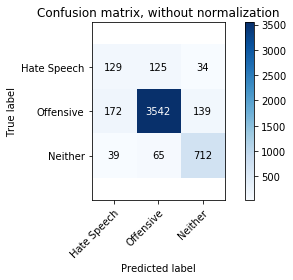

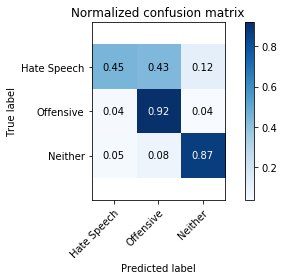

In [28]:
plot_confusion_matrices(lbl_fwd, y_pred)